# Are we the next Monet?

**Project Overview**

This Kaggle competition challenges participants to create an AI algorithm that can transform ordinary landscape photos into the style of Claude Monet's paintings. I am implementing a CycleGAN to accomplish this task.

*Key Points:*

1. **Goal**: Generate Monet-style images from photographs
2. **Method**: CycleGAN architecture
3. **Data**: Unpaired sets of Monet paintings and landscape photos
4. **Challenge**: Capture Monet's unique style while preserving the content of the original photos

In [51]:
# All project imports and GPU checking 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model 
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

if len(tf.config.experimental.list_physical_devices('GPU')) > 0:
    strategy = tf.distribute.MirroredStrategy()
    print('Using GPU strategy')
else:
    strategy = tf.distribute.get_strategy()
    print('Using default strategy')

print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.AUTOTUNE

print('TensorFlow version:', tf.__version__)

Num GPUs Available:  1
Using GPU strategy
Number of replicas: 1
TensorFlow version: 2.6.4


# Data Loading and Preparation

This section handles the loading and preprocessing of image data for the CycleGAN project:

1. **Dataset Source**: Images are loaded from Kaggle's Google Cloud Storage (GCS) using TFRecord files.

2. **Image Sets**: 
   - Monet paintings: Loaded from 'monet_tfrec/*.tfrec'
   - Landscape photos: Loaded from 'photo_tfrec/*.tfrec'

3. **Image Processing**:
   - Size: All images are 256x256 pixels
   - Decoding: JPEG images are decoded to RGB format
   - Normalization: Pixel values are scaled to [-1, 1] range

4. **TFRecord Parsing**: 
   - Each record contains image data and metadata
   - Only the image data is extracted for this project

5. **Dataset Creation**:
   - TFRecordDataset is used to efficiently load data
   - Images are batched for processing


In [52]:
# Load the Kaggle Datasets 
GCS_PATH = KaggleDatasets().get_gcs_path()

# Import the monet and landscape images
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))


# All the images for the competition are already sized to 256x256. 
IMAGE_SIZE = [256, 256]


def decode_image(image):
    # RGB images, set the channel to 3. 
    image = tf.image.decode_jpeg(image, channels=3)
    # Additionally, we need to scale the images to a [-1, 1] scale. 
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image


# Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image


# Define the function to extract the image from the files.
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

# Set batch size
BATCH_SIZE = 1

# Let's load in our datasets.
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(BATCH_SIZE)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(BATCH_SIZE)

Monet TFRecord Files: 5
Photo TFRecord Files: 20


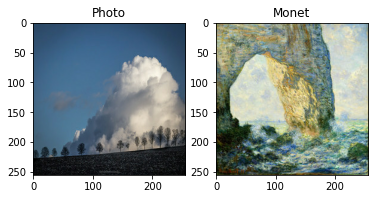

In [53]:
# Example photos of each dataset
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

# Print out the example images
plt.subplot(121);
plt.title('Photo');
plt.imshow(example_photo[0] * 0.5 + 0.5);

plt.subplot(122);
plt.title('Monet');
plt.imshow(example_monet[0] * 0.5 + 0.5);

# Exploratory Data Analysis 

The EDA for this project focuses on analyzing the color distributions, image quality, and statistical properties of both Monet paintings and landscape photographs. We examine the RGB color histograms, verify image dimensions and pixel value ranges, and calculate mean and standard deviation of pixel values for both types of images.

Monet Painting Color Distribution:


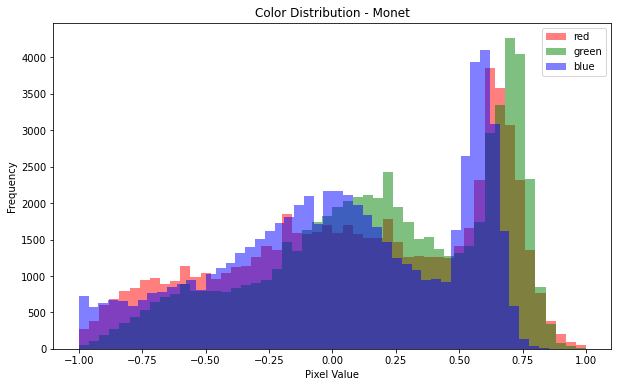

Landscape Photo Color Distribution:


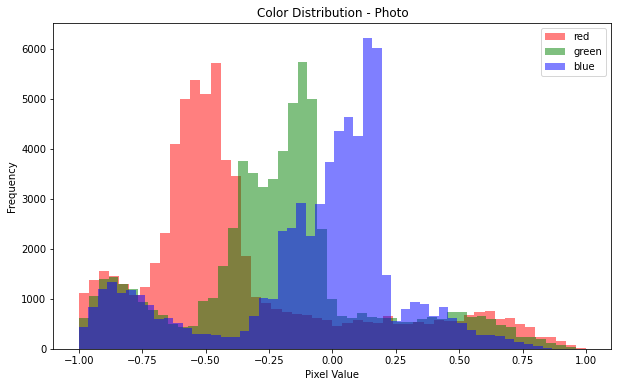

Monet Dataset Quality Check:
Number of channels: 3
Image size: (256, 256)
Pixel value range: (-1.0, 1.0)

Photo Dataset Quality Check:
Number of channels: 3
Image size: (256, 256)
Pixel value range: (-1.0, 1.0)

Monet Image Statistics:
Mean pixel values (R, G, B): [0.1061594  0.20025013 0.03659304]
Standard deviation (R, G, B): [0.497027   0.44847727 0.45898107]

Photo Image Statistics:
Mean pixel values (R, G, B): [-0.3580022  -0.2070865  -0.07391859]
Standard deviation (R, G, B): [0.43144804 0.38249862 0.36996466]



In [54]:
# Color Histograms 
def color_histogram(image, title):
    colors = ['red', 'green', 'blue']
    plt.figure(figsize=(10, 6))
    for i, color in enumerate(colors):
        values = image[0, :, :, i].numpy().flatten()
        plt.hist(values, bins=50, color=color, alpha=0.5, label=color)
    plt.legend()
    plt.title(f"Color Distribution - {title}")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.show()

print("Monet Painting Color Distribution:")
color_histogram(example_monet, "Monet")

print("Landscape Photo Color Distribution:")
color_histogram(example_photo, "Photo")

# Data Quality Check 
def check_data_quality(image, title):
    num_channels = image.shape[-1]
    image_size = image.shape[1:3]
    pixel_range = (np.min(image), np.max(image))

    print(f"{title} Dataset Quality Check:")
    print(f"Number of channels: {num_channels}")
    print(f"Image size: {image_size}")
    print(f"Pixel value range: {pixel_range}")
    print()

check_data_quality(example_monet, "Monet")
check_data_quality(example_photo, "Photo")

# Image statistics
def image_statistics(image, title):
    mean = np.mean(image, axis=(1, 2))
    std = np.std(image, axis=(1, 2))
    
    print(f"{title} Image Statistics:")
    print(f"Mean pixel values (R, G, B): {mean[0]}")
    print(f"Standard deviation (R, G, B): {std[0]}")
    print()

image_statistics(example_monet, "Monet")
image_statistics(example_photo, "Photo")

# Build the Generator

This design is based on the paper "Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks" by Zhu et al. (2017). My generator utilizes a ResNet-based architecture, which includes an encoder, a series of residual blocks, and a decoder. This architecture helps in effectively capturing and transforming image features.

*Architecture Overview*

1. **Input Layer**:
    - The generator takes an image of shape $(256 \times 256 \times 3)$ as input.

2. **Initial Convolution**:
    - The first layer is a convolutional layer with 64 filters and a kernel size of 7x7. This layer retains the input size but increases the depth to 64 channels, followed by layer normalization and a ReLU activation function.

3. **Downsampling**:
    - The downsampling path consists of two convolutional layers with 128 and 256 filters, respectively, each with a kernel size of 3x3 and a stride of 2. This reduces the spatial dimensions of the image while increasing the depth, enabling the model to capture more complex features.

4. **Residual Blocks**:
    - The core of the generator consists of nine residual blocks, each containing two convolutional layers with 256 filters. These blocks help in maintaining the consistency of image features by allowing gradients to flow through the network without vanishing. The output of each block is added to its input, promoting stable and effective learning.

5. **Upsampling**:
    - The upsampling path includes two transposed convolutional layers with 128 and 64 filters, respectively, each with a kernel size of 3x3 and a stride of 2. These layers increase the spatial dimensions of the feature maps, essentially reversing the downsampling process.

6. **Output Layer**:
    - The final layer is a convolutional layer with 3 filters and a kernel size of 7x7. This layer transforms the feature maps back into an image with three channels (RGB), using a Tanh activation function to output values in the range of [-1, 1].

*Key Components*

- **Downsample Function**: This function reduces the spatial dimensions of the input image while increasing the number of filters, using convolutional layers followed by layer normalization and Leaky ReLU activation.

- **Upsample Function**: This function increases the spatial dimensions of the feature maps, using transposed convolutional layers followed by layer normalization and ReLU activation.

- **Residual Blocks**: These blocks are the heart of the ResNet architecture, allowing for effective learning by adding the input of each block to its output, promoting gradient flow and helping maintain image details.


In [55]:
# Function for downsampling 
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        result.add(layers.LayerNormalization())
    result.add(layers.LeakyReLU(0.2))
    return result

# Upsample function for the Generator 
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    result.add(layers.LayerNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

# Residual block 
def resnet_block(input_layer, filters):
    initializer = tf.random_normal_initializer(0., 0.02)
    out = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer=initializer)(input_layer)
    out = layers.LayerNormalization()(out)
    out = layers.ReLU()(out)

    out = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer=initializer)(out)
    out = layers.LayerNormalization()(out)

    return layers.add([out, input_layer])

# ResNet-based generator
def Generator():
    inputs = layers.Input(shape=[256, 256, 3])
    initializer = tf.random_normal_initializer(0., 0.02)

    x = layers.Conv2D(64, kernel_size=7, strides=1, padding='same', kernel_initializer=initializer)(inputs)
    x = layers.LayerNormalization()(x)
    x = layers.ReLU()(x)

    # Downsampling
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same', kernel_initializer=initializer)(x)
    x = layers.LayerNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', kernel_initializer=initializer)(x)
    x = layers.LayerNormalization()(x)
    x = layers.ReLU()(x)

    # Residual blocks
    for _ in range(9):
        x = resnet_block(x, 256)

    # Upsampling
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', kernel_initializer=initializer)(x)
    x = layers.LayerNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', kernel_initializer=initializer)(x)
    x = layers.LayerNormalization()(x)
    x = layers.ReLU()(x)

    # Output layer
    outputs = layers.Conv2D(3, kernel_size=7, strides=1, padding='same', kernel_initializer=initializer, activation='tanh')(x)

    return Model(inputs=inputs, outputs=outputs)


generator = Generator()
generator.summary()


Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_304 (Conv2D)             (None, 256, 256, 64) 9472        input_14[0][0]                   
__________________________________________________________________________________________________
layer_normalization_307 (LayerN (None, 256, 256, 64) 128         conv2d_304[0][0]                 
__________________________________________________________________________________________________
re_lu_154 (ReLU)                (None, 256, 256, 64) 0           layer_normalization_307[0][0]    
___________________________________________________________________________________________

# Discriminator

The discriminator in our CycleGAN model is designed to differentiate between real and generated images. It follows a similar structure to the PatchGAN discriminator used in the original CycleGAN paper.

*Architecture Overview*

1. **Input Layer**:
    - The discriminator takes an image of shape $(256 \times 256 \times 3)$ as input.

2. **Downsampling**:
    - The discriminator uses four downsampling layers to progressively reduce the spatial dimensions of the input image while increasing the number of filters:
        - The first downsampling layer has 64 filters with a kernel size of 4x4 and a stride of 2. This layer does not apply instance normalization.
        - The second downsampling layer has 128 filters with a kernel size of 4x4 and a stride of 2.
        - The third downsampling layer has 256 filters with a kernel size of 4x4 and a stride of 2.
        - The fourth downsampling layer has 512 filters with a kernel size of 4x4 and a stride of 2.
    - Each downsampling layer uses a convolutional layer followed by layer normalization and Leaky ReLU activation.

3. **Zero Padding and Convolution**:
    - After the downsampling layers, zero padding is applied to the feature maps to adjust their spatial dimensions.
    - A convolutional layer with 512 filters, a kernel size of 4x4, and a stride of 1 is applied to the padded feature maps, further processing the image features. This layer is followed by layer normalization and Leaky ReLU activation.

4. **Output Layer**:
    - Another zero padding layer is applied to the feature maps.
    - The final layer is a convolutional layer with 1 filter and a kernel size of 4x4. This layer outputs a single-channel image that represents the patch-wise classification of the input image. The output is not activated, as it will be used for binary classification during training.

*Key Components*

- **Downsample Function**: This function reduces the spatial dimensions of the input image while increasing the number of filters, using convolutional layers followed by layer normalization and Leaky ReLU activation. The first downsampling layer does not apply instance normalization to preserve more raw features from the input.

- **Zero Padding**: Zero padding is used to maintain the spatial dimensions required for the convolutional layers to operate correctly.

- **Convolutional Layers**: These layers are responsible for extracting features from the input image and progressively refining them through downsampling and zero padding.



In [56]:
# Discriminator function based on the original CycleGAN paper
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, apply_instancenorm=False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)
    down4 = downsample(512, 4)(down3)  # (bs, 16, 16, 512)

    zero_pad1 = layers.ZeroPadding2D()(down4)  # (bs, 18, 18, 512)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)  # (bs, 15, 15, 512)

    norm1 = layers.LayerNormalization()(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 17, 17, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)  # (bs, 14, 14, 1)

    return Model(inputs=inp, outputs=last)

discriminator = Discriminator()
discriminator.summary()


Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_108 (Sequential)  (None, 128, 128, 64)      3072      
_________________________________________________________________
sequential_109 (Sequential)  (None, 64, 64, 128)       131328    
_________________________________________________________________
sequential_110 (Sequential)  (None, 32, 32, 256)       524800    
_________________________________________________________________
sequential_111 (Sequential)  (None, 16, 16, 512)       2098176   
_________________________________________________________________
zero_padding2d_26 (ZeroPaddi (None, 18, 18, 512)       0         
_________________________________________________________________
conv2d_330 (Conv2D)          (None, 15, 15, 512)       419

Initialize the Generator and Discriminators for each class below and show the untrained image print out. 

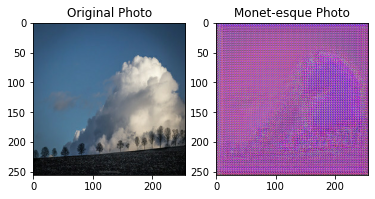

In [57]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos


to_monet = monet_generator(example_photo)

# Show untrained monet photo
plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

# Build the CycleGAN model

We will subclass a `tf.keras.Model` so that we can run `fit()` later to train our model. During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.


In [58]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Define loss functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.


In [59]:
# Discriminator Loss
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
# Generator Loss  
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    

# Calculate the total cycle loss 
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1
    
# Identity Loss
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train the CycleGAN

Let's compile our model. Since we used `tf.keras.Model` to build our CycleGAN, we can just ude the `fit` function to train our model.

In [60]:
# Optimizers
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
# Model Compile     
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

# Train and fit the model     
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
300/300 [==============================] - 173s 434ms/step - monet_gen_loss: 10.7761 - photo_gen_loss: 10.8029 - monet_disc_loss: 0.7550 - photo_disc_loss: 0.7447
Epoch 2/25
300/300 [==============================] - 135s 434ms/step - monet_gen_loss: 8.1764 - photo_gen_loss: 8.4335 - monet_disc_loss: 0.6735 - photo_disc_loss: 0.6797
Epoch 3/25
300/300 [==============================] - 135s 434ms/step - monet_gen_loss: 7.4447 - photo_gen_loss: 7.6559 - monet_disc_loss: 0.6685 - photo_disc_loss: 0.6642
Epoch 4/25
300/300 [==============================] - 135s 434ms/step - monet_gen_loss: 7.1465 - photo_gen_loss: 7.2793 - monet_disc_loss: 0.6568 - photo_disc_loss: 0.6506
Epoch 5/25
300/300 [==============================] - 135s 434ms/step - monet_gen_loss: 6.8615 - photo_gen_loss: 6.9696 - monet_disc_loss: 0.6529 - photo_disc_loss: 0.6642
Epoch 6/25
300/300 [==============================] - 135s 434ms/step - monet_gen_loss: 6.7087 - photo_gen_loss: 6.7898 - monet_disc_loss:

# Visualize our Monet-esque photos

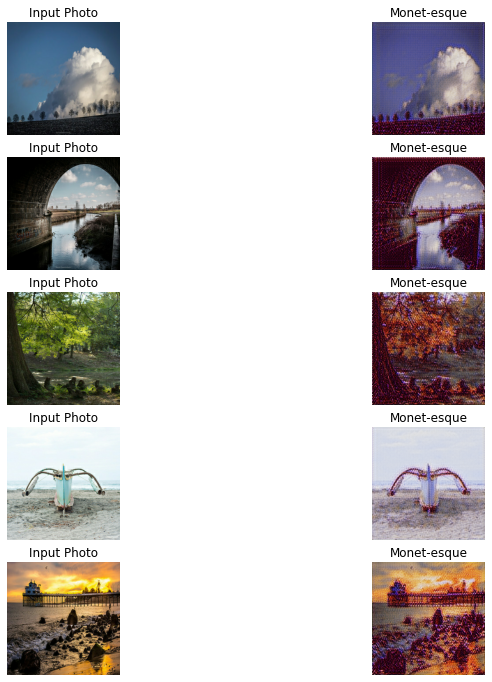

In [61]:
# Show plots of new images
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Create submission file

Submit the zip file for the competition. 

In [62]:
# Create a new image directory 
import PIL
! mkdir ../images

# Save the images 
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

# Output the images to zip for submission
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'